# IA Propensity Train.

In [2]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import product
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix, roc_auc_score,
    roc_curve, precision_recall_curve, precision_score, recall_score, f1_score
)
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import (
    train_test_split, cross_val_score, learning_curve, validation_curve
)
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from tabulate import tabulate


sns.set_theme(style="whitegrid")

In [3]:
df = pd.read_csv("data/raw/IA_PROPENSITY_TRAIN.csv", index_col=0)
df.head()

,PRODUCTO,TIPO_CARROCERIA,COMBUSTIBLE,Potencia,TRANS,FORMA_PAGO,ESTADO_CIVIL,GENERO,OcupaciOn,PROVINCIA,...,Zona_Renta,REV_Garantia,Averia_grave,QUEJA_CAC,COSTE_VENTA,km_anno,Mas_1_coche,Revisiones,Edad_Cliente,Tiempo
CODE,,,,,,,,,,,,,,,,,,,,,
CLI1,A,TIPO1,FUEL 1,Baja,M,Contado,CASADO,M,Empresa,Asturias,...,Medio-Bajo,NO DATA,Averia muy grave,SI,2892,0,False,2,18,0
CLI2,A,TIPO1,FUEL 1,Baja,M,Contado,CASADO,F,Empresa,Toledo,...,Medio-Bajo,SI,No,NO,1376,7187,False,2,53,0
CLI3,A,TIPO1,FUEL 1,Baja,M,Otros,CASADO,M,Empresa,Lerida,...,Medio,NO DATA,No,NO,1376,0,True,4,21,3
CLI4,A,TIPO1,FUEL 1,Baja,M,Financiera Marca,CASADO,F,Empresa,Madrid,...,Medio,SI,Averia muy grave,SI,2015,7256,True,4,48,5
CLI5,A,TIPO1,FUEL 1,Baja,M,Financiera Marca,CASADO,F,Funcionario,Santa Cruz de Tenerife,...,Alto,NO DATA,No,NO,1818,0,True,3,21,3


In [4]:
df.shape

(58049, 23)

In [5]:
df.dtypes

PRODUCTO           object
TIPO_CARROCERIA    object
COMBUSTIBLE        object
Potencia           object
TRANS              object
FORMA_PAGO         object
ESTADO_CIVIL       object
GENERO             object
OcupaciOn          object
PROVINCIA          object
Campanna1          object
Campanna2          object
Campanna3          object
Zona_Renta         object
REV_Garantia       object
Averia_grave       object
QUEJA_CAC          object
COSTE_VENTA         int64
km_anno             int64
Mas_1_coche          bool
Revisiones          int64
Edad_Cliente        int64
Tiempo              int64
dtype: object

## Gráficas

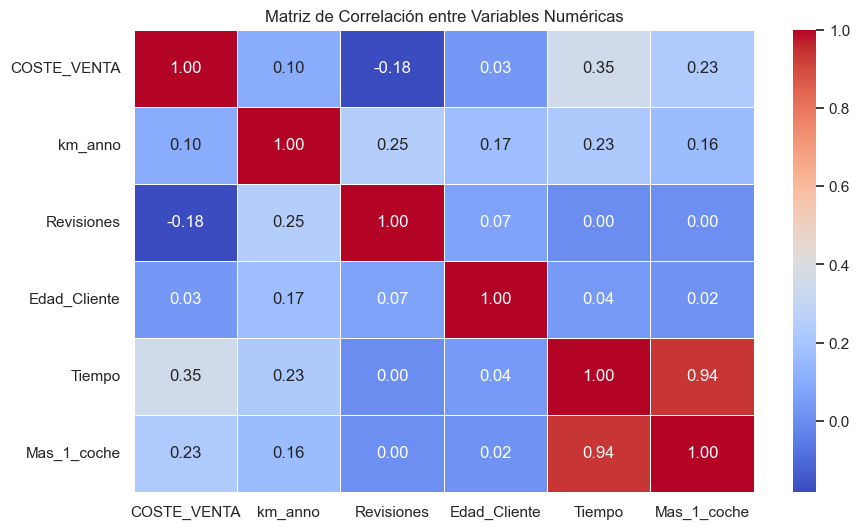

In [6]:
# Selecting numerical columns for correlation analysis
numerical_cols = ['COSTE_VENTA', 'km_anno', 'Revisiones', 'Edad_Cliente', 'Tiempo', 'Mas_1_coche']

# Compute the correlation matrix
corr_matrix = df[numerical_cols].corr()

# Plot the heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Matriz de Correlación entre Variables Numéricas")
plt.show()

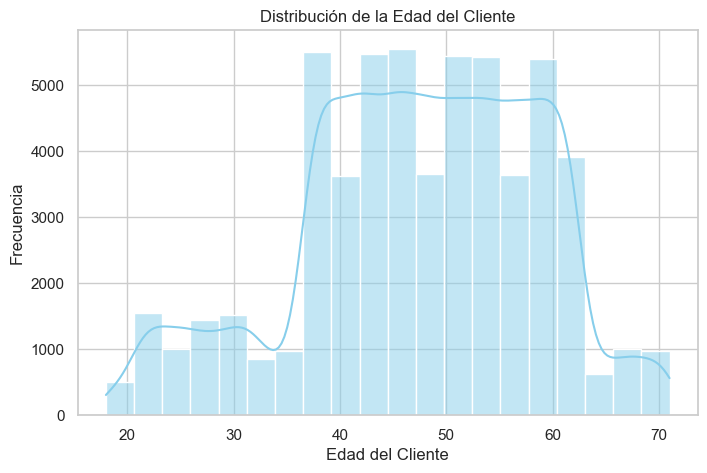

In [7]:
# Histograma de la distribución de la edad del cliente
plt.figure(figsize=(8, 5))
sns.histplot(df["Edad_Cliente"], bins=20, kde=True, color="skyblue")
plt.title("Distribución de la Edad del Cliente")
plt.xlabel("Edad del Cliente")
plt.ylabel("Frecuencia")
plt.show()

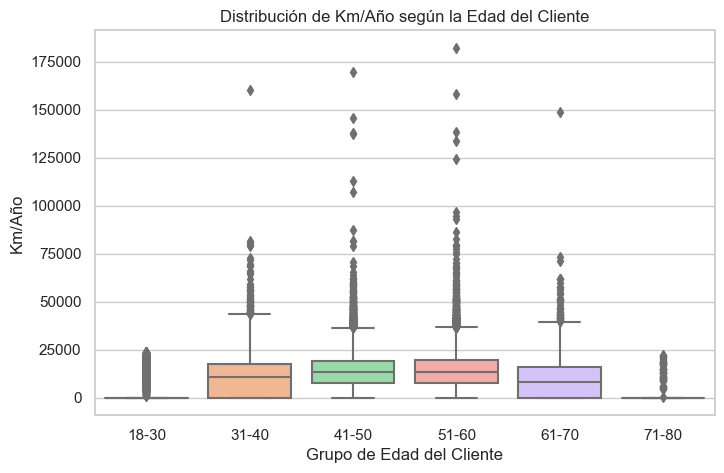

In [8]:
# Boxplot de kilómetros por año según la edad del cliente (agrupada por décadas)
df["Grupo_Edad"] = pd.cut(df["Edad_Cliente"], bins=[18, 30, 40, 50, 60, 70, 80], labels=["18-30", "31-40", "41-50", "51-60", "61-70", "71-80"])
plt.figure(figsize=(8, 5))
sns.boxplot(x="Grupo_Edad", y="km_anno", data=df, palette="pastel")
plt.title("Distribución de Km/Año según la Edad del Cliente")
plt.xlabel("Grupo de Edad del Cliente")
plt.ylabel("Km/Año")
plt.show()

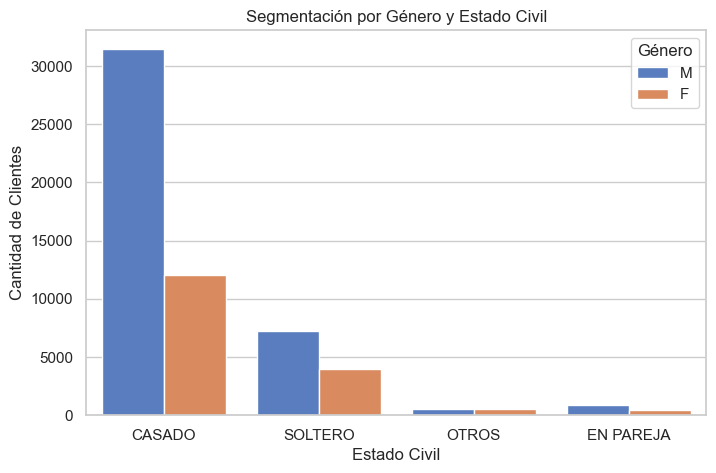

In [9]:
# Gráfico de barras de la cantidad de clientes por género y estado civil
plt.figure(figsize=(8, 5))
sns.countplot(x="ESTADO_CIVIL", hue="GENERO", data=df, palette="muted")
plt.title("Segmentación por Género y Estado Civil")
plt.xlabel("Estado Civil")
plt.ylabel("Cantidad de Clientes")
plt.legend(title="Género")
plt.show()

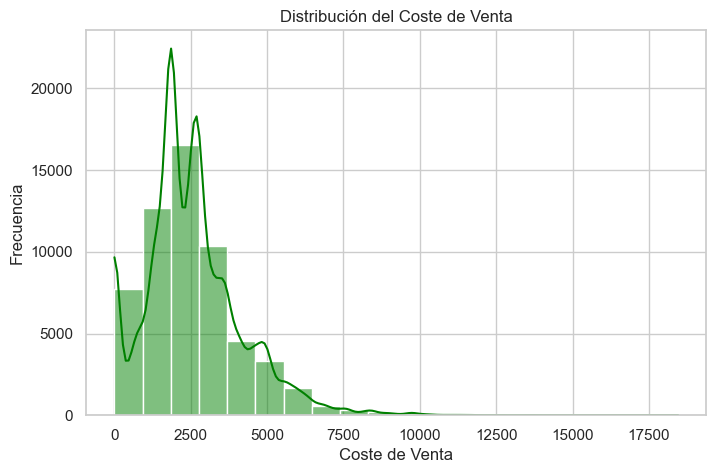

In [10]:
# Histograma del coste de venta
plt.figure(figsize=(8, 5))
sns.histplot(df["COSTE_VENTA"], bins=20, kde=True, color="green")
plt.title("Distribución del Coste de Venta")
plt.xlabel("Coste de Venta")
plt.ylabel("Frecuencia")
plt.show()

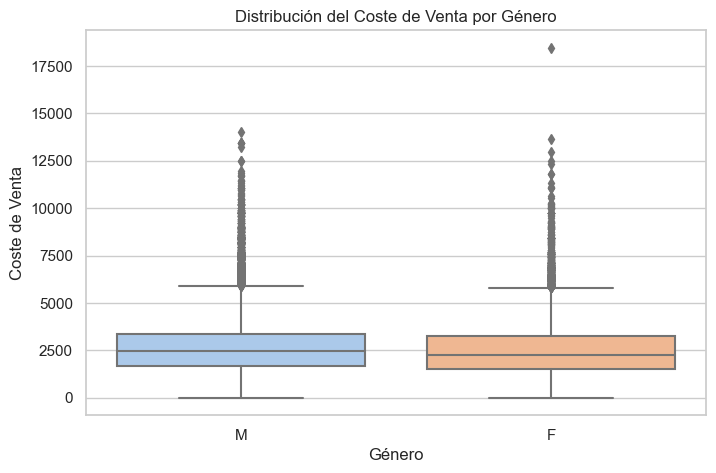

In [11]:
# Boxplot del coste de venta según el género
plt.figure(figsize=(8, 5))
sns.boxplot(x="GENERO", y="COSTE_VENTA", data=df, palette="pastel")
plt.title("Distribución del Coste de Venta por Género")
plt.xlabel("Género")
plt.ylabel("Coste de Venta")
plt.show()

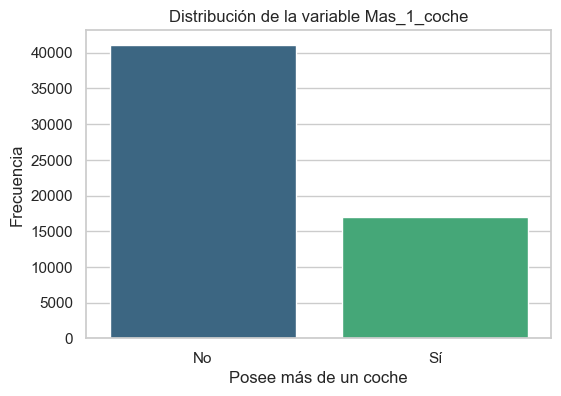

In [12]:
# Conteo de valores de la variable 'Mas_1_coche'
plt.figure(figsize=(6, 4))
sns.countplot(data=df, x='Mas_1_coche', palette='viridis')
plt.title('Distribución de la variable Mas_1_coche')
plt.xlabel('Posee más de un coche')
plt.ylabel('Frecuencia')
plt.xticks([0, 1], ['No', 'Sí'])
plt.show()

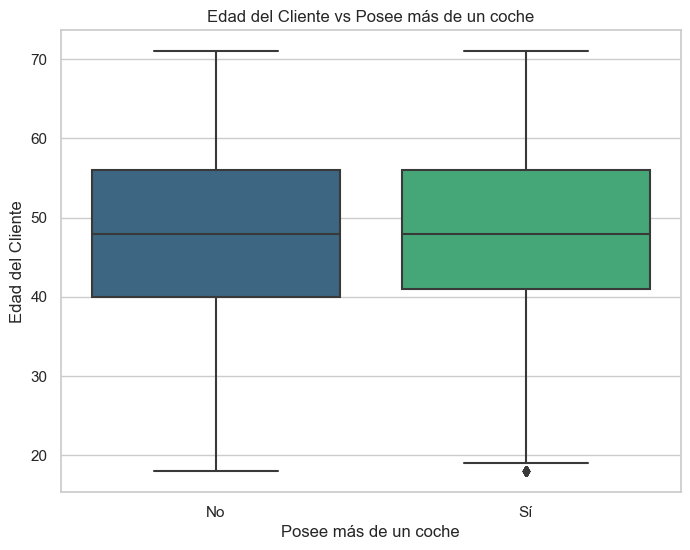

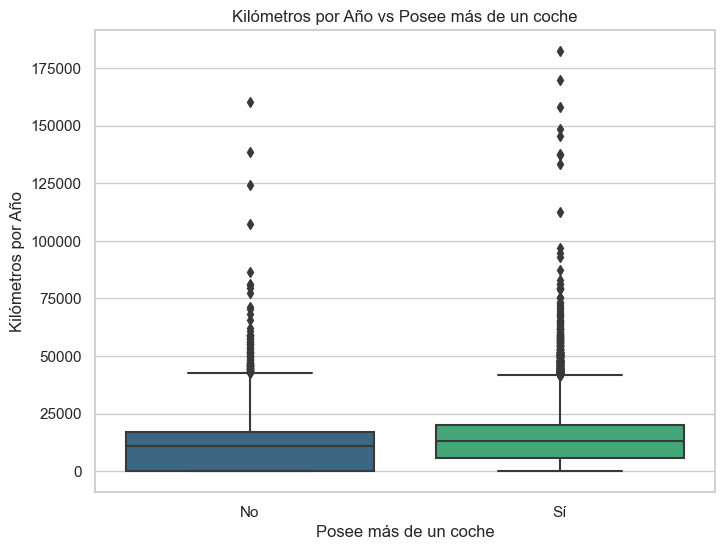

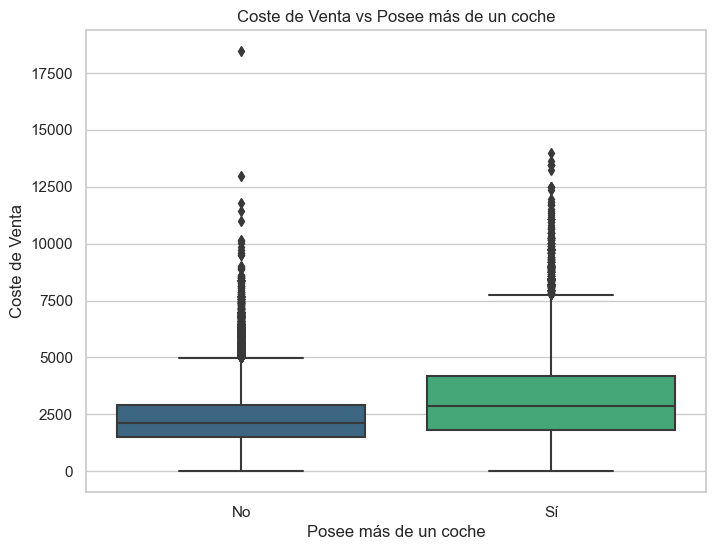

In [13]:
# Boxplot de 'Edad_Cliente' vs 'Mas_1_coche'
plt.figure(figsize=(8, 6))
sns.boxplot(data=df, x='Mas_1_coche', y='Edad_Cliente', palette='viridis')
plt.title('Edad del Cliente vs Posee más de un coche')
plt.xlabel('Posee más de un coche')
plt.ylabel('Edad del Cliente')
plt.xticks([0, 1], ['No', 'Sí'])
plt.show()

# Boxplot de 'km_anno' vs 'Mas_1_coche'
plt.figure(figsize=(8, 6))
sns.boxplot(data=df, x='Mas_1_coche', y='km_anno', palette='viridis')
plt.title('Kilómetros por Año vs Posee más de un coche')
plt.xlabel('Posee más de un coche')
plt.ylabel('Kilómetros por Año')
plt.xticks([0, 1], ['No', 'Sí'])
plt.show()

# Boxplot de 'COSTE_VENTA' vs 'Mas_1_coche'
plt.figure(figsize=(8, 6))
sns.boxplot(data=df, x='Mas_1_coche', y='COSTE_VENTA', palette='viridis')
plt.title('Coste de Venta vs Posee más de un coche')
plt.xlabel('Posee más de un coche')
plt.ylabel('Coste de Venta')
plt.xticks([0, 1], ['No', 'Sí'])
plt.show()

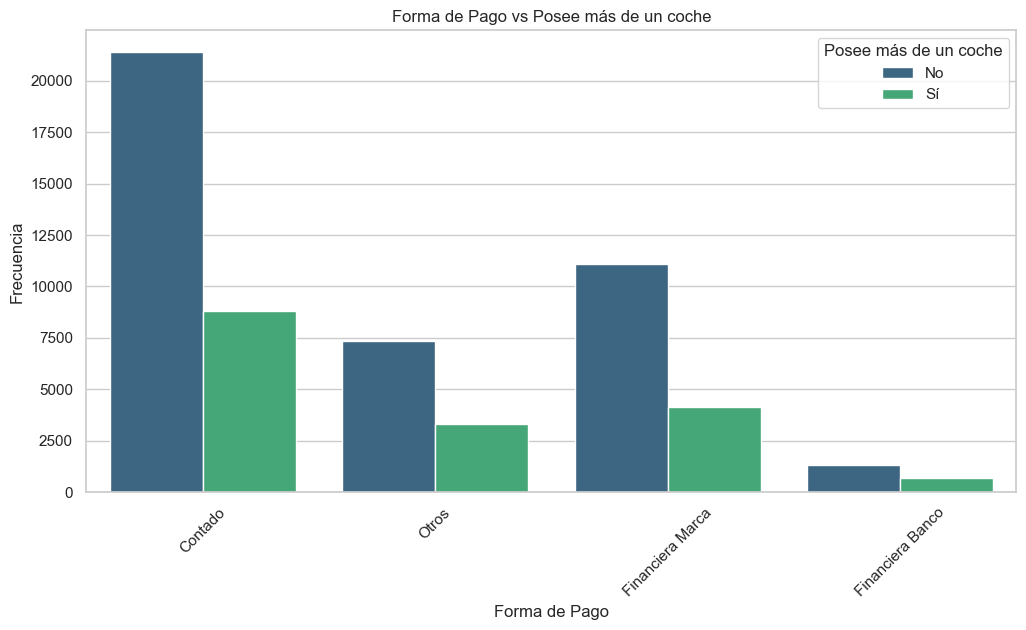

In [14]:
# Gráfico de barras de 'FORMA_PAGO' vs 'Mas_1_coche'
plt.figure(figsize=(12, 6))
sns.countplot(data=df, x='FORMA_PAGO', hue='Mas_1_coche', palette='viridis')
plt.title('Forma de Pago vs Posee más de un coche')
plt.xlabel('Forma de Pago')
plt.ylabel('Frecuencia')
plt.legend(title='Posee más de un coche', labels=['No', 'Sí'])
plt.xticks(rotation=45)
plt.show()

## Limpieza de datos

In [15]:
# Contar los valores nulos por columna
valores_nulos = df.isnull().sum()
print(valores_nulos)

PRODUCTO               0
TIPO_CARROCERIA        0
COMBUSTIBLE            0
Potencia               0
TRANS                  0
FORMA_PAGO             0
ESTADO_CIVIL         890
GENERO               860
OcupaciOn              0
PROVINCIA              0
Campanna1              0
Campanna2              0
Campanna3              0
Zona_Renta         13178
REV_Garantia           0
Averia_grave           1
QUEJA_CAC              0
COSTE_VENTA            0
km_anno                0
Mas_1_coche            0
Revisiones             0
Edad_Cliente           0
Tiempo                 0
Grupo_Edad           161
dtype: int64


In [16]:
# Seleccionar columnas de tipo 'object'
columnas_object = df.select_dtypes(include=['object']).columns
print(columnas_object)

Index(['PRODUCTO', 'TIPO_CARROCERIA', 'COMBUSTIBLE', 'Potencia', 'TRANS',
       'FORMA_PAGO', 'ESTADO_CIVIL', 'GENERO', 'OcupaciOn', 'PROVINCIA',
       'Campanna1', 'Campanna2', 'Campanna3', 'Zona_Renta', 'REV_Garantia',
       'Averia_grave', 'QUEJA_CAC'],
      dtype='object')


In [17]:
# Rellenar valores nulos con 'Desconocido'
df['ESTADO_CIVIL'] = df['ESTADO_CIVIL'].fillna('Desconocido')
df['GENERO'] = df['GENERO'].fillna('Desconocido')
df['Zona_Renta'] = df['Zona_Renta'].fillna('Desconocido')
df['Averia_grave'] = df['Averia_grave'].fillna('Desconocido')

In [18]:
df['Grupo_Edad'] = df['Grupo_Edad'].cat.add_categories(['Desconocido'])
df['Grupo_Edad'] = df['Grupo_Edad'].fillna('Desconocido')

In [19]:
valores_nulos = df.isnull().sum()
print(valores_nulos)

PRODUCTO           0
TIPO_CARROCERIA    0
COMBUSTIBLE        0
Potencia           0
TRANS              0
FORMA_PAGO         0
ESTADO_CIVIL       0
GENERO             0
OcupaciOn          0
PROVINCIA          0
Campanna1          0
Campanna2          0
Campanna3          0
Zona_Renta         0
REV_Garantia       0
Averia_grave       0
QUEJA_CAC          0
COSTE_VENTA        0
km_anno            0
Mas_1_coche        0
Revisiones         0
Edad_Cliente       0
Tiempo             0
Grupo_Edad         0
dtype: int64


### Más de un coche

In [20]:
df['Mas_1_coche'].unique()

array([False,  True])

In [21]:
label_encoder = LabelEncoder()
df['Mas_1_coche'] = label_encoder.fit_transform(df['Mas_1_coche'])

In [22]:
columns = df.columns.tolist()
index = columns.index('Mas_1_coche')
columns.insert(index + 1, columns.pop())
df = df[columns]

In [23]:
df.head()

,PRODUCTO,TIPO_CARROCERIA,COMBUSTIBLE,Potencia,TRANS,FORMA_PAGO,ESTADO_CIVIL,GENERO,OcupaciOn,PROVINCIA,...,REV_Garantia,Averia_grave,QUEJA_CAC,COSTE_VENTA,km_anno,Mas_1_coche,Grupo_Edad,Revisiones,Edad_Cliente,Tiempo
CODE,,,,,,,,,,,,,,,,,,,,,
CLI1,A,TIPO1,FUEL 1,Baja,M,Contado,CASADO,M,Empresa,Asturias,...,NO DATA,Averia muy grave,SI,2892,0,0,Desconocido,2,18,0
CLI2,A,TIPO1,FUEL 1,Baja,M,Contado,CASADO,F,Empresa,Toledo,...,SI,No,NO,1376,7187,0,51-60,2,53,0
CLI3,A,TIPO1,FUEL 1,Baja,M,Otros,CASADO,M,Empresa,Lerida,...,NO DATA,No,NO,1376,0,1,18-30,4,21,3
CLI4,A,TIPO1,FUEL 1,Baja,M,Financiera Marca,CASADO,F,Empresa,Madrid,...,SI,Averia muy grave,SI,2015,7256,1,41-50,4,48,5
CLI5,A,TIPO1,FUEL 1,Baja,M,Financiera Marca,CASADO,F,Funcionario,Santa Cruz de Tenerife,...,NO DATA,No,NO,1818,0,1,18-30,3,21,3


### Producto

In [24]:
df['PRODUCTO'].unique()

array(['A', 'B', 'C', 'H', 'J', 'D', 'I', 'E', 'F', 'K', 'G'],
      dtype=object)

In [25]:
label_encoder = LabelEncoder()
df['PRODUCTO'] = label_encoder.fit_transform(df['PRODUCTO'])

In [26]:
columns = df.columns.tolist()
index = columns.index('PRODUCTO')
columns.insert(index + 1, columns.pop())
df = df[columns]

In [27]:
df.head(2)

,PRODUCTO,Tiempo,TIPO_CARROCERIA,COMBUSTIBLE,Potencia,TRANS,FORMA_PAGO,ESTADO_CIVIL,GENERO,OcupaciOn,...,Zona_Renta,REV_Garantia,Averia_grave,QUEJA_CAC,COSTE_VENTA,km_anno,Mas_1_coche,Grupo_Edad,Revisiones,Edad_Cliente
CODE,,,,,,,,,,,,,,,,,,,,,
CLI1,0,0,TIPO1,FUEL 1,Baja,M,Contado,CASADO,M,Empresa,...,Medio-Bajo,NO DATA,Averia muy grave,SI,2892,0,0,Desconocido,2,18
CLI2,0,0,TIPO1,FUEL 1,Baja,M,Contado,CASADO,F,Empresa,...,Medio-Bajo,SI,No,NO,1376,7187,0,51-60,2,53


### TIPO_CARROCERIA

In [28]:
df['TIPO_CARROCERIA'].unique()

array(['TIPO1', 'TIPO6', 'TIPO4', 'TIPO7', 'TIPO8', 'TIPO2', 'TIPO3',
       'TIPO5'], dtype=object)

In [29]:
label_encoder = LabelEncoder()
df['TIPO_CARROCERIA'] = label_encoder.fit_transform(df['TIPO_CARROCERIA'])

In [30]:
columns = df.columns.tolist()
index = columns.index('TIPO_CARROCERIA')
columns.insert(index + 1, columns.pop())
df = df[columns]

In [31]:
df.head(2)

,PRODUCTO,Tiempo,TIPO_CARROCERIA,Edad_Cliente,COMBUSTIBLE,Potencia,TRANS,FORMA_PAGO,ESTADO_CIVIL,GENERO,...,Campanna3,Zona_Renta,REV_Garantia,Averia_grave,QUEJA_CAC,COSTE_VENTA,km_anno,Mas_1_coche,Grupo_Edad,Revisiones
CODE,,,,,,,,,,,,,,,,,,,,,
CLI1,0,0,0,18,FUEL 1,Baja,M,Contado,CASADO,M,...,NO,Medio-Bajo,NO DATA,Averia muy grave,SI,2892,0,0,Desconocido,2
CLI2,0,0,0,53,FUEL 1,Baja,M,Contado,CASADO,F,...,NO,Medio-Bajo,SI,No,NO,1376,7187,0,51-60,2


### COMBUSTIBLE

In [32]:
df['COMBUSTIBLE'].unique()

array(['FUEL 1', 'FUEL 2'], dtype=object)

In [33]:
label_encoder = LabelEncoder()
df['COMBUSTIBLE'] = label_encoder.fit_transform(df['COMBUSTIBLE'])

In [34]:
columns = df.columns.tolist()
index = columns.index('COMBUSTIBLE')
columns.insert(index + 1, columns.pop())
df = df[columns]

In [35]:
df.head(2)

,PRODUCTO,Tiempo,TIPO_CARROCERIA,Edad_Cliente,COMBUSTIBLE,Revisiones,Potencia,TRANS,FORMA_PAGO,ESTADO_CIVIL,...,Campanna2,Campanna3,Zona_Renta,REV_Garantia,Averia_grave,QUEJA_CAC,COSTE_VENTA,km_anno,Mas_1_coche,Grupo_Edad
CODE,,,,,,,,,,,,,,,,,,,,,
CLI1,0,0,0,18,0,2,Baja,M,Contado,CASADO,...,NO,NO,Medio-Bajo,NO DATA,Averia muy grave,SI,2892,0,0,Desconocido
CLI2,0,0,0,53,0,2,Baja,M,Contado,CASADO,...,NO,NO,Medio-Bajo,SI,No,NO,1376,7187,0,51-60


### Potencia

In [36]:
df['Potencia'].unique()

array(['Baja', 'Media', 'Alta'], dtype=object)

In [37]:
ordinal_encoder = OrdinalEncoder()
df['Potencia'] = ordinal_encoder.fit_transform(df['Potencia'].values.reshape(-1, 1))

In [38]:
columns = df.columns.tolist()
index = columns.index('Potencia')
columns.insert(index + 1, columns.pop())
df = df[columns]

In [39]:
df.head(2)

,PRODUCTO,Tiempo,TIPO_CARROCERIA,Edad_Cliente,COMBUSTIBLE,Revisiones,Potencia,Grupo_Edad,TRANS,FORMA_PAGO,...,Campanna1,Campanna2,Campanna3,Zona_Renta,REV_Garantia,Averia_grave,QUEJA_CAC,COSTE_VENTA,km_anno,Mas_1_coche
CODE,,,,,,,,,,,,,,,,,,,,,
CLI1,0,0,0,18,0,2,1.0,Desconocido,M,Contado,...,SI,NO,NO,Medio-Bajo,NO DATA,Averia muy grave,SI,2892,0,0
CLI2,0,0,0,53,0,2,1.0,51-60,M,Contado,...,NO,NO,NO,Medio-Bajo,SI,No,NO,1376,7187,0


### TRANS

In [40]:
df['TRANS'].unique()

array(['M', 'A'], dtype=object)

In [41]:
label_encoder = LabelEncoder()
df['TRANS'] = label_encoder.fit_transform(df['TRANS'])

In [42]:
columns = df.columns.tolist()
index = columns.index('TRANS')
columns.insert(index + 1, columns.pop())
df = df[columns]

In [43]:
df.head(2)

,PRODUCTO,Tiempo,TIPO_CARROCERIA,Edad_Cliente,COMBUSTIBLE,Revisiones,Potencia,Grupo_Edad,TRANS,Mas_1_coche,...,PROVINCIA,Campanna1,Campanna2,Campanna3,Zona_Renta,REV_Garantia,Averia_grave,QUEJA_CAC,COSTE_VENTA,km_anno
CODE,,,,,,,,,,,,,,,,,,,,,
CLI1,0,0,0,18,0,2,1.0,Desconocido,1,0,...,Asturias,SI,NO,NO,Medio-Bajo,NO DATA,Averia muy grave,SI,2892,0
CLI2,0,0,0,53,0,2,1.0,51-60,1,0,...,Toledo,NO,NO,NO,Medio-Bajo,SI,No,NO,1376,7187


### FORMA PAGO

In [44]:
df['FORMA_PAGO'].unique()

array(['Contado', 'Otros', 'Financiera Marca', 'Financiera Banco'],
      dtype=object)

In [45]:
label_encoder = LabelEncoder()
df['FORMA_PAGO'] = label_encoder.fit_transform(df['FORMA_PAGO'])

In [46]:
columns = df.columns.tolist()
index = columns.index('FORMA_PAGO')
columns.insert(index + 1, columns.pop())
df = df[columns]

In [47]:
df.head(2)

,PRODUCTO,Tiempo,TIPO_CARROCERIA,Edad_Cliente,COMBUSTIBLE,Revisiones,Potencia,Grupo_Edad,TRANS,Mas_1_coche,...,OcupaciOn,PROVINCIA,Campanna1,Campanna2,Campanna3,Zona_Renta,REV_Garantia,Averia_grave,QUEJA_CAC,COSTE_VENTA
CODE,,,,,,,,,,,,,,,,,,,,,
CLI1,0,0,0,18,0,2,1.0,Desconocido,1,0,...,Empresa,Asturias,SI,NO,NO,Medio-Bajo,NO DATA,Averia muy grave,SI,2892
CLI2,0,0,0,53,0,2,1.0,51-60,1,0,...,Empresa,Toledo,NO,NO,NO,Medio-Bajo,SI,No,NO,1376


### ESTADO CIVIL

In [48]:
df['ESTADO_CIVIL'].unique()

array(['CASADO', 'SOLTERO', 'OTROS', 'EN PAREJA', 'Desconocido'],
      dtype=object)

In [49]:
label_encoder = LabelEncoder()
df['ESTADO_CIVIL'] = label_encoder.fit_transform(df['ESTADO_CIVIL'])

In [50]:
columns = df.columns.tolist()
index = columns.index('ESTADO_CIVIL')
columns.insert(index + 1, columns.pop())
df = df[columns]

In [51]:
df.head(2)

,PRODUCTO,Tiempo,TIPO_CARROCERIA,Edad_Cliente,COMBUSTIBLE,Revisiones,Potencia,Grupo_Edad,TRANS,Mas_1_coche,...,GENERO,OcupaciOn,PROVINCIA,Campanna1,Campanna2,Campanna3,Zona_Renta,REV_Garantia,Averia_grave,QUEJA_CAC
CODE,,,,,,,,,,,,,,,,,,,,,
CLI1,0,0,0,18,0,2,1.0,Desconocido,1,0,...,M,Empresa,Asturias,SI,NO,NO,Medio-Bajo,NO DATA,Averia muy grave,SI
CLI2,0,0,0,53,0,2,1.0,51-60,1,0,...,F,Empresa,Toledo,NO,NO,NO,Medio-Bajo,SI,No,NO


### GENERO

In [52]:
df['GENERO'].unique()

array(['M', 'F', 'Desconocido'], dtype=object)

In [53]:
label_encoder = LabelEncoder()
df['GENERO'] = label_encoder.fit_transform(df['GENERO'])

In [54]:
columns = df.columns.tolist()
index = columns.index('GENERO')
columns.insert(index + 1, columns.pop())
df = df[columns]

In [55]:
df.head(2)

,PRODUCTO,Tiempo,TIPO_CARROCERIA,Edad_Cliente,COMBUSTIBLE,Revisiones,Potencia,Grupo_Edad,TRANS,Mas_1_coche,...,GENERO,QUEJA_CAC,OcupaciOn,PROVINCIA,Campanna1,Campanna2,Campanna3,Zona_Renta,REV_Garantia,Averia_grave
CODE,,,,,,,,,,,,,,,,,,,,,
CLI1,0,0,0,18,0,2,1.0,Desconocido,1,0,...,2,SI,Empresa,Asturias,SI,NO,NO,Medio-Bajo,NO DATA,Averia muy grave
CLI2,0,0,0,53,0,2,1.0,51-60,1,0,...,1,NO,Empresa,Toledo,NO,NO,NO,Medio-Bajo,SI,No


### Ocupación

In [56]:
df['OcupaciOn'].unique()

array(['Empresa', 'Funcionario', 'Autonomo'], dtype=object)

In [57]:
label_encoder = LabelEncoder()
df['OcupaciOn'] = label_encoder.fit_transform(df['OcupaciOn'])

In [58]:
columns = df.columns.tolist()
index = columns.index('OcupaciOn')
columns.insert(index + 1, columns.pop())
df = df[columns]

In [59]:
df.head(2)

,PRODUCTO,Tiempo,TIPO_CARROCERIA,Edad_Cliente,COMBUSTIBLE,Revisiones,Potencia,Grupo_Edad,TRANS,Mas_1_coche,...,GENERO,QUEJA_CAC,OcupaciOn,Averia_grave,PROVINCIA,Campanna1,Campanna2,Campanna3,Zona_Renta,REV_Garantia
CODE,,,,,,,,,,,,,,,,,,,,,
CLI1,0,0,0,18,0,2,1.0,Desconocido,1,0,...,2,SI,1,Averia muy grave,Asturias,SI,NO,NO,Medio-Bajo,NO DATA
CLI2,0,0,0,53,0,2,1.0,51-60,1,0,...,1,NO,1,No,Toledo,NO,NO,NO,Medio-Bajo,SI


### PROVINCIA

In [60]:
df['PROVINCIA'].unique()

array(['Asturias', 'Toledo', 'Lerida', 'Madrid', 'Santa Cruz de Tenerife',
       'Pontevedra', 'Lacoruna', 'Barcelona', 'Cordoba', 'Guipuzcua',
       'Valladolid', 'Castellon', 'Valencia', 'Las Palmas', 'La Rioja',
       'Baleares', 'Zaragoza', 'Alicante', 'Tarragona', 'Leon', 'Lugo',
       'Badajoz', 'Vizcaya', 'Sevilla', 'Guadalajara', 'Ciudad Real',
       'Cantabria', 'Orense', 'Navarra', 'Gerona', 'Malaga', 'Jaen',
       'Murcia', 'Burgos', 'Granada', 'Alava', 'Cuenca', 'Cadiz',
       'Salamanca', 'Albacete', 'Almeria', 'Teruel', 'Segovia',
       'Palencia', 'Huelva', 'Huesca', 'Zamora', 'Avila', 'Soria',
       'Caceres', 'Melilla', 'Ceuta', 'Francia'], dtype=object)

In [61]:
label_encoder = LabelEncoder()
df['PROVINCIA'] = label_encoder.fit_transform(df['PROVINCIA'])

In [62]:
columns = df.columns.tolist()
index = columns.index('PROVINCIA')
columns.insert(index + 1, columns.pop())
df = df[columns]

In [63]:
df.head(2)

,PRODUCTO,Tiempo,TIPO_CARROCERIA,Edad_Cliente,COMBUSTIBLE,Revisiones,Potencia,Grupo_Edad,TRANS,Mas_1_coche,...,GENERO,QUEJA_CAC,OcupaciOn,Averia_grave,PROVINCIA,REV_Garantia,Campanna1,Campanna2,Campanna3,Zona_Renta
CODE,,,,,,,,,,,,,,,,,,,,,
CLI1,0,0,0,18,0,2,1.0,Desconocido,1,0,...,2,SI,1,Averia muy grave,4,NO DATA,SI,NO,NO,Medio-Bajo
CLI2,0,0,0,53,0,2,1.0,51-60,1,0,...,1,NO,1,No,47,SI,NO,NO,NO,Medio-Bajo


### Campanna1

In [64]:
df['Campanna1'].unique()

array(['SI', 'NO'], dtype=object)

In [65]:
label_encoder = LabelEncoder()
df['Campanna1'] = label_encoder.fit_transform(df['Campanna1'])

In [66]:
columns = df.columns.tolist()
index = columns.index('Campanna1')
columns.insert(index + 1, columns.pop())
df = df[columns]

In [67]:
df.head(2)

,PRODUCTO,Tiempo,TIPO_CARROCERIA,Edad_Cliente,COMBUSTIBLE,Revisiones,Potencia,Grupo_Edad,TRANS,Mas_1_coche,...,GENERO,QUEJA_CAC,OcupaciOn,Averia_grave,PROVINCIA,REV_Garantia,Campanna1,Zona_Renta,Campanna2,Campanna3
CODE,,,,,,,,,,,,,,,,,,,,,
CLI1,0,0,0,18,0,2,1.0,Desconocido,1,0,...,2,SI,1,Averia muy grave,4,NO DATA,1,Medio-Bajo,NO,NO
CLI2,0,0,0,53,0,2,1.0,51-60,1,0,...,1,NO,1,No,47,SI,0,Medio-Bajo,NO,NO


### Campanna2

In [68]:
df['Campanna2'].unique()

array(['NO', 'SI'], dtype=object)

In [69]:
label_encoder = LabelEncoder()
df['Campanna2'] = label_encoder.fit_transform(df['Campanna2'])

In [70]:
columns = df.columns.tolist()
index = columns.index('Campanna2')
columns.insert(index + 1, columns.pop())
df = df[columns]

In [71]:
df.head(2)

,PRODUCTO,Tiempo,TIPO_CARROCERIA,Edad_Cliente,COMBUSTIBLE,Revisiones,Potencia,Grupo_Edad,TRANS,Mas_1_coche,...,GENERO,QUEJA_CAC,OcupaciOn,Averia_grave,PROVINCIA,REV_Garantia,Campanna1,Zona_Renta,Campanna2,Campanna3
CODE,,,,,,,,,,,,,,,,,,,,,
CLI1,0,0,0,18,0,2,1.0,Desconocido,1,0,...,2,SI,1,Averia muy grave,4,NO DATA,1,Medio-Bajo,0,NO
CLI2,0,0,0,53,0,2,1.0,51-60,1,0,...,1,NO,1,No,47,SI,0,Medio-Bajo,0,NO


### Campanna3

In [72]:
df['Campanna3'].unique()

array(['NO', 'SI'], dtype=object)

In [73]:
label_encoder = LabelEncoder()
df['Campanna3'] = label_encoder.fit_transform(df['Campanna3'])

In [74]:
columns = df.columns.tolist()
index = columns.index('Campanna3')
columns.insert(index + 1, columns.pop())
df = df[columns]

In [75]:
df.head(2)

,PRODUCTO,Tiempo,TIPO_CARROCERIA,Edad_Cliente,COMBUSTIBLE,Revisiones,Potencia,Grupo_Edad,TRANS,Mas_1_coche,...,GENERO,QUEJA_CAC,OcupaciOn,Averia_grave,PROVINCIA,REV_Garantia,Campanna1,Zona_Renta,Campanna2,Campanna3
CODE,,,,,,,,,,,,,,,,,,,,,
CLI1,0,0,0,18,0,2,1.0,Desconocido,1,0,...,2,SI,1,Averia muy grave,4,NO DATA,1,Medio-Bajo,0,0
CLI2,0,0,0,53,0,2,1.0,51-60,1,0,...,1,NO,1,No,47,SI,0,Medio-Bajo,0,0


### Zona Renta

In [76]:
df['Zona_Renta'].unique()

array(['Medio-Bajo', 'Medio', 'Alto', 'Desconocido', 'Otros'],
      dtype=object)

In [77]:
ordinal_encoder = OrdinalEncoder()
df['Zona_Renta'] = ordinal_encoder.fit_transform(df['Zona_Renta'].values.reshape(-1, 1))

In [78]:
columns = df.columns.tolist()
index = columns.index('Zona_Renta')
columns.insert(index + 1, columns.pop())
df = df[columns]

In [79]:
df.head(2)

,PRODUCTO,Tiempo,TIPO_CARROCERIA,Edad_Cliente,COMBUSTIBLE,Revisiones,Potencia,Grupo_Edad,TRANS,Mas_1_coche,...,GENERO,QUEJA_CAC,OcupaciOn,Averia_grave,PROVINCIA,REV_Garantia,Campanna1,Zona_Renta,Campanna3,Campanna2
CODE,,,,,,,,,,,,,,,,,,,,,
CLI1,0,0,0,18,0,2,1.0,Desconocido,1,0,...,2,SI,1,Averia muy grave,4,NO DATA,1,3.0,0,0
CLI2,0,0,0,53,0,2,1.0,51-60,1,0,...,1,NO,1,No,47,SI,0,3.0,0,0


### REV_Garantia

In [80]:
df['REV_Garantia'].unique()

array(['NO DATA', 'SI'], dtype=object)

In [81]:
label_encoder = LabelEncoder()
df['REV_Garantia'] = label_encoder.fit_transform(df['REV_Garantia'])

In [82]:
columns = df.columns.tolist()
index = columns.index('REV_Garantia')
columns.insert(index + 1, columns.pop())
df = df[columns]

In [83]:
df.head(2)

,PRODUCTO,Tiempo,TIPO_CARROCERIA,Edad_Cliente,COMBUSTIBLE,Revisiones,Potencia,Grupo_Edad,TRANS,Mas_1_coche,...,GENERO,QUEJA_CAC,OcupaciOn,Averia_grave,PROVINCIA,REV_Garantia,Campanna2,Campanna1,Zona_Renta,Campanna3
CODE,,,,,,,,,,,,,,,,,,,,,
CLI1,0,0,0,18,0,2,1.0,Desconocido,1,0,...,2,SI,1,Averia muy grave,4,0,0,1,3.0,0
CLI2,0,0,0,53,0,2,1.0,51-60,1,0,...,1,NO,1,No,47,1,0,0,3.0,0


### Averia grave

In [84]:
df['Averia_grave'].unique()

array(['Averia muy grave', 'No', 'Averia leve', 'Averia grave',
       'Desconocido'], dtype=object)

In [85]:
OrdinalEncoder = OrdinalEncoder()
df['Averia_grave'] = ordinal_encoder.fit_transform(df['Averia_grave'].values.reshape(-1, 1))

In [86]:
columns = df.columns.tolist()
index = columns.index('Averia_grave')
columns.insert(index + 1, columns.pop())
df = df[columns]

In [87]:
df.head(2)

,PRODUCTO,Tiempo,TIPO_CARROCERIA,Edad_Cliente,COMBUSTIBLE,Revisiones,Potencia,Grupo_Edad,TRANS,Mas_1_coche,...,GENERO,QUEJA_CAC,OcupaciOn,Averia_grave,Campanna3,PROVINCIA,REV_Garantia,Campanna2,Campanna1,Zona_Renta
CODE,,,,,,,,,,,,,,,,,,,,,
CLI1,0,0,0,18,0,2,1.0,Desconocido,1,0,...,2,SI,1,2.0,0,4,0,0,1,3.0
CLI2,0,0,0,53,0,2,1.0,51-60,1,0,...,1,NO,1,4.0,0,47,1,0,0,3.0


### QUEJA CAC

In [88]:
df['QUEJA_CAC'].unique()

array(['SI', 'NO'], dtype=object)

In [89]:
label_encoder = LabelEncoder()
df['QUEJA_CAC'] = label_encoder.fit_transform(df['QUEJA_CAC'])

In [90]:
columns = df.columns.tolist()
index = columns.index('QUEJA_CAC')
columns.insert(index + 1, columns.pop())
df = df[columns]

In [91]:
df.head(2)

,PRODUCTO,Tiempo,TIPO_CARROCERIA,Edad_Cliente,COMBUSTIBLE,Revisiones,Potencia,Grupo_Edad,TRANS,Mas_1_coche,...,GENERO,QUEJA_CAC,Zona_Renta,OcupaciOn,Averia_grave,Campanna3,PROVINCIA,REV_Garantia,Campanna2,Campanna1
CODE,,,,,,,,,,,,,,,,,,,,,
CLI1,0,0,0,18,0,2,1.0,Desconocido,1,0,...,2,1,3.0,1,2.0,0,4,0,0,1
CLI2,0,0,0,53,0,2,1.0,51-60,1,0,...,1,0,3.0,1,4.0,0,47,1,0,0


### Grupo Edad

In [92]:
df['Grupo_Edad'].unique()

['Desconocido', '51-60', '18-30', '41-50', '31-40', '61-70', '71-80']
Categories (7, object): ['18-30' < '31-40' < '41-50' < '51-60' < '61-70' < '71-80' < 'Desconocido']

In [93]:
df['Grupo_Edad'] = df['Grupo_Edad'].astype('category')

In [94]:
df['Grupo_Edad_Codificado'] = df['Grupo_Edad'].cat.codes

In [95]:
# Definimos un diccionario que mapea cada rango de edad a un número
mapa_edades = {
    '18-30': 1,
    '31-40': 2,
    '41-50': 3,
    '51-60': 4,
    '61-70': 5,
    '71-80': 6,
    'Desconocido': 0  # Asignamos 0 para valores desconocidos
}

# Aplicamos el mapeo a la columna 'Grupo_Edad'
df['Grupo_Edad_Codificado'] = df['Grupo_Edad'].map(mapa_edades)

In [96]:
# Verificamos los primeros registros para asegurarnos de que la conversión es correcta
print(df[['Grupo_Edad', 'Grupo_Edad_Codificado']].head())

       Grupo_Edad Grupo_Edad_Codificado
CODE                                   
CLI1  Desconocido                     0
CLI2        51-60                     4
CLI3        18-30                     1
CLI4        41-50                     3
CLI5        18-30                     1


In [97]:
df.drop(columns=['Grupo_Edad'], inplace=True)

In [98]:
df.head(2)

,PRODUCTO,Tiempo,TIPO_CARROCERIA,Edad_Cliente,COMBUSTIBLE,Revisiones,Potencia,TRANS,Mas_1_coche,FORMA_PAGO,...,QUEJA_CAC,Zona_Renta,OcupaciOn,Averia_grave,Campanna3,PROVINCIA,REV_Garantia,Campanna2,Campanna1,Grupo_Edad_Codificado
CODE,,,,,,,,,,,,,,,,,,,,,
CLI1,0,0,0,18,0,2,1.0,1,0,0,...,1,3.0,1,2.0,0,4,0,0,1,0
CLI2,0,0,0,53,0,2,1.0,1,0,0,...,0,3.0,1,4.0,0,47,1,0,0,4


In [99]:
# Guardar el archivo limpiado
df.to_csv("data/stg/IA_PROPENSITY_TRAIN_LIMPIO.csv")

## Entrenamiento del modelo

In [100]:
df = pd.read_csv("data/stg/IA_PROPENSITY_TRAIN_LIMPIO.csv", index_col=0)
df.head()

,PRODUCTO,Tiempo,TIPO_CARROCERIA,Edad_Cliente,COMBUSTIBLE,Revisiones,Potencia,TRANS,Mas_1_coche,FORMA_PAGO,...,QUEJA_CAC,Zona_Renta,OcupaciOn,Averia_grave,Campanna3,PROVINCIA,REV_Garantia,Campanna2,Campanna1,Grupo_Edad_Codificado
CODE,,,,,,,,,,,,,,,,,,,,,
CLI1,0,0,0,18,0,2,1.0,1,0,0,...,1,3.0,1,2.0,0,4,0,0,1,0
CLI2,0,0,0,53,0,2,1.0,1,0,0,...,0,3.0,1,4.0,0,47,1,0,0,4
CLI3,0,3,0,21,0,4,1.0,1,1,3,...,0,2.0,1,4.0,0,30,0,0,0,1
CLI4,0,5,0,48,0,4,1.0,1,1,2,...,1,2.0,1,2.0,0,32,1,0,1,3
CLI5,0,3,0,21,0,3,1.0,1,1,2,...,0,0.0,2,4.0,1,41,0,0,1,1


In [ ]:
# Supongamos que 'Mas_de_1_coche' es la variable objetivo
X = df.drop(columns=['Mas_1_coche', 'Tiempo'])
y = df['Mas_1_coche']

In [102]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [103]:
y_train.value_counts()

0    28657
1    11977
Name: Mas_1_coche, dtype: int64

In [104]:
y_test.value_counts()

0    12450
1     4965
Name: Mas_1_coche, dtype: int64

In [105]:
rf_model = RandomForestClassifier(
                                    random_state=42,
                                    n_estimators=100,
                                    min_samples_split=5)
rf_model.fit(X_train, y_train)

RandomForestClassifier(min_samples_split=5, random_state=42)

In [106]:
cv_scores = cross_val_score(rf_model, X_train, y_train, cv=5, scoring='accuracy')
cv_scores

array([0.85308232, 0.84852959, 0.85086748, 0.8554202 , 0.84986463])

In [107]:
print("Train set score (Accuracy) =", rf_model.score(X_train, y_train))
print("Test set score (Accuracy) =", rf_model.score(X_test, y_test))

conf_mat = confusion_matrix(y_test, rf_model.predict(X_test))

num_classes = conf_mat.shape[0]

print(tabulate(
    conf_mat,
    headers=[f'Pred Class {i}' for i in range(num_classes)],
    showindex=[f'Real Class {i}' for i in range(num_classes)],
    tablefmt='fancy_grid'
))

print("\nClassification Report:")
print(classification_report(y_test, rf_model.predict(X_test)))

Train set score (Accuracy) = 0.9911404242752375
Test set score (Accuracy) = 0.8608096468561585
╒══════════════╤════════════════╤════════════════╕
│              │   Pred Class 0 │   Pred Class 1 │
╞══════════════╪════════════════╪════════════════╡
│ Real Class 0 │          11503 │            947 │
├──────────────┼────────────────┼────────────────┤
│ Real Class 1 │           1477 │           3488 │
╘══════════════╧════════════════╧════════════════╛

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.92      0.90     12450
           1       0.79      0.70      0.74      4965

    accuracy                           0.86     17415
   macro avg       0.84      0.81      0.82     17415
weighted avg       0.86      0.86      0.86     17415



## Hiperparámetros

## Random Forest

In [109]:
# Definir los parámetros para la búsqueda de Grid
param_grid = {
    'criterion' : ['entropy', 'gini', 'log_loss'],  # Función para medir la calidad de la división (por defecto: 'gini')
    'n_estimators' : [500],  # Número de árboles en el bosque (por defecto: 100)
    'max_depths' : [3, 10],  # Profundidad máxima del árbol (por defecto: None - crece hasta la pureza total)
    'min_samples_splits' : [8, 10, 15],  # Número mínimo de muestras para dividir un nodo (por defecto: 2)
    'min_samples_leafs' : [10],  # Número mínimo de muestras en una hoja (por defecto: 1)
    'max_features': ['sqrt'],  # Número de características consideradas en cada división (por defecto: 'sqrt')
    'bootstrap' : [True],  # Si se usa muestreo con reemplazo (por defecto: True)
    'class_weight' : [None],  # Ponderación de clases (por defecto: None)
    'min_weight_fraction_leaf' :[0.0],  # Fracción mínima del peso de muestras requeridas en una hoja (por defecto: 0.0)
    'max_leaf_nodes' : [None],  # Número máximo de nodos hoja en el árbol (por defecto: None - sin límite)
    'warm_start' : [False]  # Reutilizar árboles previos para acelerar entrenamiento (por defecto: False)
}

# Almacenar los resultados
results = []

# Iterar sobre todas las combinaciones de hiperparámetros
for params in product(*param_grid.values()):
    criterion, max_depth, min_samples_split, min_samples_leaf, n_estimators, max_features, bootstrap, class_weight, min_weight_fraction_leaf, max_leaf_nodes, warm_start = params
    
    # Construir el modelo RandomForest con class_weight='balanced'
    model = RandomForestClassifier(
        criterion=criterion, 
        max_depth=max_depth, 
        min_samples_split=min_samples_split, 
        min_samples_leaf=min_samples_leaf,
        n_estimators=n_estimators,
        class_weight='balanced',  # <-- Agregado para mejorar recall
        random_state=42
    )
    
    # Entrenar el modelo
    model.fit(X_train, y_train)
    
    # Predecir en el conjunto de prueba
    y_pred_proba = model.predict_proba(X_test)[:, 1]  # Probabilidades
    y_pred = (y_pred_proba > 0.4).astype(int)  # <-- Ajustar umbral de decisión (antes era 0.5)
    
    # Calcular métricas
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')  # <-- Enfocarse en recall
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    
    # Validación cruzada
    cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='recall')  # <-- Optimizar recall
    mean_cv_score = np.mean(cv_scores)
    
    # Guardar los resultados
    results.append({
        'criterion': criterion,
        'max_depth': max_depth,
        'min_samples_split': min_samples_split,
        'min_samples_leaf': min_samples_leaf,
        'n_estimators': n_estimators,
        'accuracy': accuracy,
        'f1_score': f1,
        'recall': recall,  # <-- Priorizar recall
        'roc_auc': roc_auc,
        'cv_recall': mean_cv_score  # <-- Guardar recall en validación cruzada
    })

# Convertir a DataFrame y ordenar por recall
results_df = pd.DataFrame(results).sort_values(by=['recall', 'f1_score'], ascending=False)

# Mostrar los mejores modelos optimizados para recall
display(results_df.head(5))

,criterion,max_depth,min_samples_split,min_samples_leaf,n_estimators,accuracy,f1_score,recall,roc_auc,cv_recall
1,entropy,500,3,10,10,0.802412,0.811522,0.802412,0.920743,0.840696
4,entropy,500,10,10,10,0.802412,0.811522,0.802412,0.920743,0.840696
13,log_loss,500,3,10,10,0.802412,0.811522,0.802412,0.920743,0.840696
16,log_loss,500,10,10,10,0.802412,0.811522,0.802412,0.920743,0.840696
0,entropy,500,3,8,10,0.801550,0.810571,0.801550,0.916403,0.837022


In [110]:
from sklearn.metrics import  ConfusionMatrixDisplay

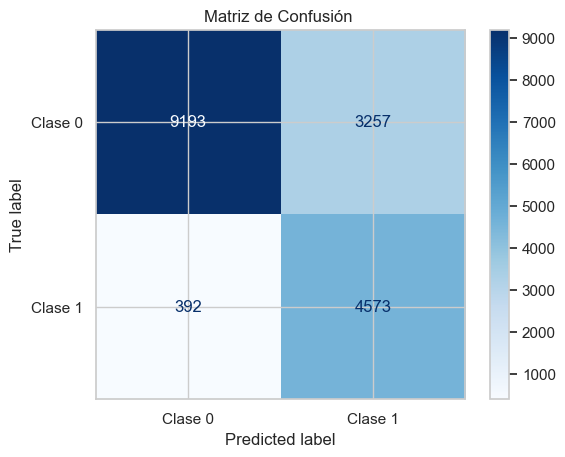

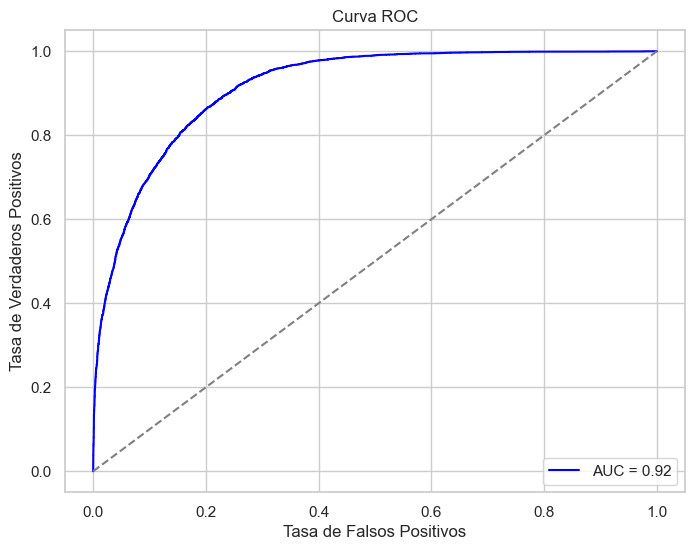

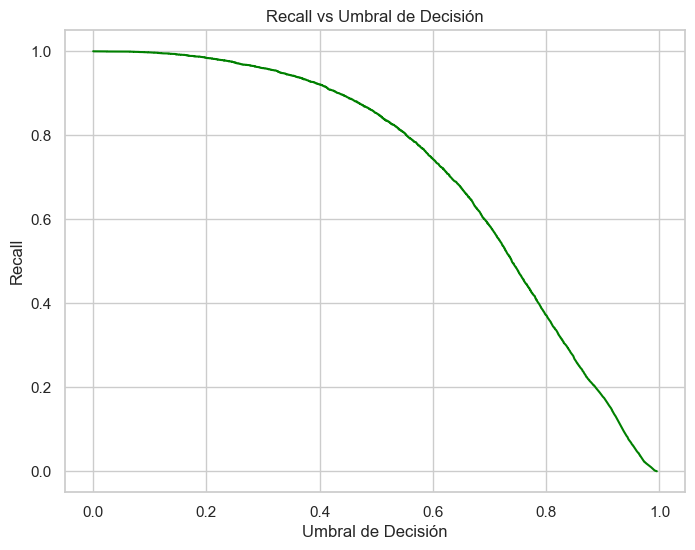

In [111]:
# Calcular la matriz de confusión
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Clase 0', 'Clase 1'])
disp.plot(cmap=plt.cm.Blues)
plt.title(f'Matriz de Confusión ')
plt.show()

# Calcular la curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

# Graficar la Curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'AUC = {roc_auc_score(y_test, y_pred_proba):.2f}')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.title(f'Curva ROC')
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# Graficar Recall vs Umbral de decisión
plt.figure(figsize=(8, 6))
plt.plot(thresholds, tpr, label='Recall', color='green')
plt.title('Recall vs Umbral de Decisión')
plt.xlabel('Umbral de Decisión')
plt.ylabel('Recall')
plt.grid(True)
plt.show()

## XGBoost

In [112]:
import xgboost as xgb
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier

In [114]:
from itertools import product
import random
import xgboost as xgb
from sklearn.metrics import (accuracy_score, f1_score, recall_score, 
                             confusion_matrix, classification_report, roc_auc_score, roc_curve, precision_recall_curve)
from sklearn.model_selection import cross_val_score
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Definir hiperparámetros a iterar
param_grid = {
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [500],
    'max_depth': [10],
    'min_child_weight': [1, 5, 10],
    'subsample': [1.0],
    'colsample_bytree': [0.8, 1.0],
    'reg_alpha': [0, 0.1, 1],
    'reg_lambda': [1, 10],
    'gamma': [0, 0.1, 1],
    'scale_pos_weight': [1, 2],
    'base_score': [0.5],
    'random_state': [38],
    'verbosity': [1]
}

# Almacenar resultados
results = []

# Iterar sobre 100 combinaciones aleatorias de hiperparámetros
for params in random.sample(list(product(*param_grid.values())), 100):
    (learning_rate, n_estimators, max_depth, min_child_weight, subsample, 
     colsample_bytree, reg_alpha, reg_lambda, gamma, scale_pos_weight, 
     base_score, random_state, verbosity) = params
    
    # Construir el modelo con los hiperparámetros actuales
    model = xgb.XGBClassifier(
        objective='binary:logistic',
        eval_metric='logloss',
        learning_rate=learning_rate,
        n_estimators=n_estimators,
        max_depth=max_depth, 
        min_child_weight=min_child_weight, 
        subsample=subsample,
        colsample_bytree=colsample_bytree,
        reg_alpha=reg_alpha,
        reg_lambda=reg_lambda,
        gamma=gamma,
        scale_pos_weight=scale_pos_weight,
        base_score=base_score,
        random_state=random_state,
        verbosity=verbosity,
        use_label_encoder=False,
        n_jobs=-1
    )
    
    # Entrenar el modelo
    model.fit(X_train, y_train)
    
    # Predecir en el conjunto de prueba
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    y_pred = (y_pred_proba > 0.4).astype(int)
    
    # Calcular métricas
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    
    # Validación cruzada
    cv_scores = cross_val_score(model, X_train, y_train, cv=3, scoring='recall')
    mean_cv_score = np.mean(cv_scores)
    
    # Guardar los resultados
    results.append({
        'learning_rate': learning_rate,
        'n_estimators': n_estimators,
        'max_depth': max_depth,
        'min_child_weight': min_child_weight,
        'subsample': subsample,
        'colsample_bytree': colsample_bytree,
        'reg_alpha': reg_alpha,
        'reg_lambda': reg_lambda,
        'gamma': gamma,
        'scale_pos_weight': scale_pos_weight,
        'accuracy': accuracy,
        'f1_score': f1,
        'recall': recall,
        'roc_auc': roc_auc,
        'cv_recall': mean_cv_score
    })

# Convertir resultados a DataFrame y ordenar por recall
results_df = pd.DataFrame(results).sort_values(by=['recall', 'f1_score'], ascending=False)

# Mostrar los mejores modelos optimizados para recall
display(results_df.head(5))

,learning_rate,n_estimators,max_depth,min_child_weight,subsample,colsample_bytree,reg_alpha,reg_lambda,gamma,scale_pos_weight,accuracy,f1_score,recall,roc_auc,cv_recall
80,0.1,500,10,1,1.0,1.0,0.0,1,0.0,1,0.871662,0.872917,0.871662,0.949714,0.747381
71,0.2,500,10,5,1.0,0.8,0.1,10,0.1,1,0.870887,0.872828,0.870887,0.948959,0.739560
18,0.1,500,10,1,1.0,0.8,1.0,10,0.1,1,0.870112,0.872033,0.870112,0.949920,0.744208
75,0.1,500,10,5,1.0,0.8,0.1,1,0.0,1,0.869767,0.871393,0.869767,0.948726,0.744282
89,0.1,500,10,1,1.0,1.0,0.0,1,0.1,1,0.869681,0.871228,0.869681,0.949546,0.745758


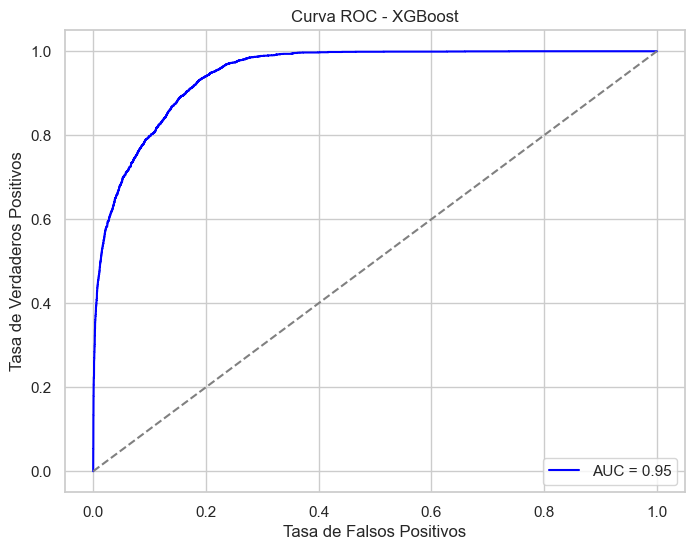

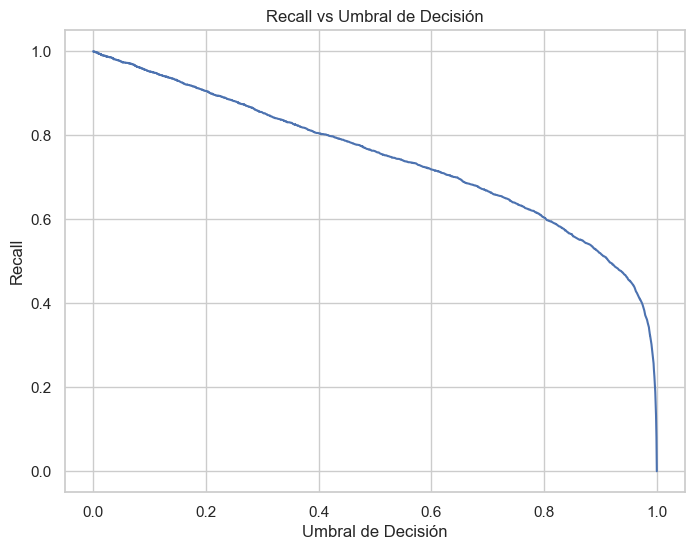

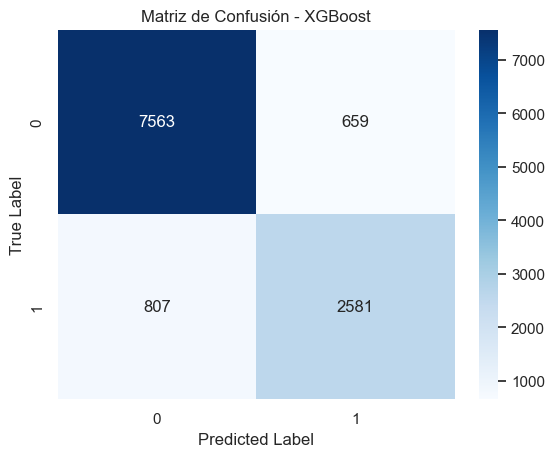

In [120]:
# Graficar la Curva ROC y Recall vs Umbral para el mejor modelo
model = results_df.iloc[0].to_dict()
model_obj = xgb.XGBClassifier(
    n_estimators=int(model['n_estimators']),
    max_depth=int(model['max_depth']),
    learning_rate=float(model['learning_rate']),
    random_state=38,
    use_label_encoder=False,
    eval_metric='logloss'
)
model_obj.fit(X_train, y_train)

# Calcular probabilidades de la clase positiva
y_pred_proba = model_obj.predict_proba(X_test)[:, 1]

# Calcular la curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

# Graficar la Curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'AUC = {roc_auc_score(y_test, y_pred_proba):.2f}')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.title(f'Curva ROC - XGBoost')
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# Graficar Recall vs Umbral
plt.figure(figsize=(8, 6))
plt.plot(thresholds, tpr, label='Recall')
plt.title('Recall vs Umbral de Decisión')
plt.xlabel('Umbral de Decisión')
plt.ylabel('Recall')
plt.grid(True)
plt.show()

# Matriz de Confusión
y_pred = model_obj.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

# Mostrar la matriz de confusión
disp = sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title(f'Matriz de Confusión - XGBoost')
plt.show()

## ADABOOST

,n_estimators,learning_rate,estimator_depth,accuracy,f1_score,recall,roc_auc,cv_score,train_score,overfitting
1,500,0.68,7,0.869337,0.867434,0.869337,0.945437,0.864274,0.914210,OK
0,500,0.67,7,0.867097,0.865803,0.867097,0.946540,0.865824,0.921165,OK
2,500,0.69,7,0.866581,0.865044,0.866581,0.944237,0.865243,0.911626,OK


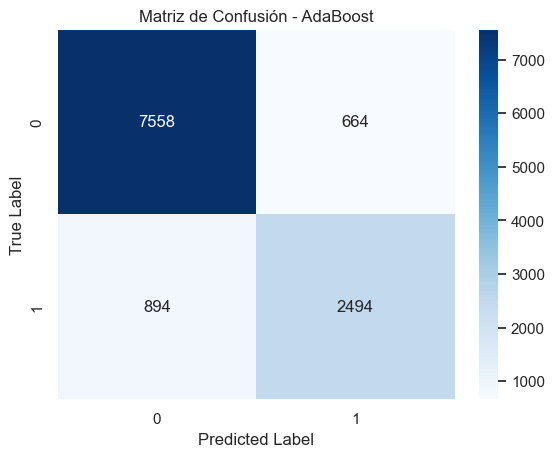

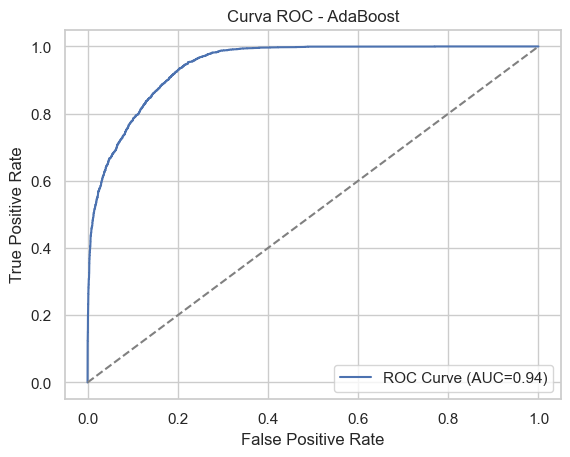

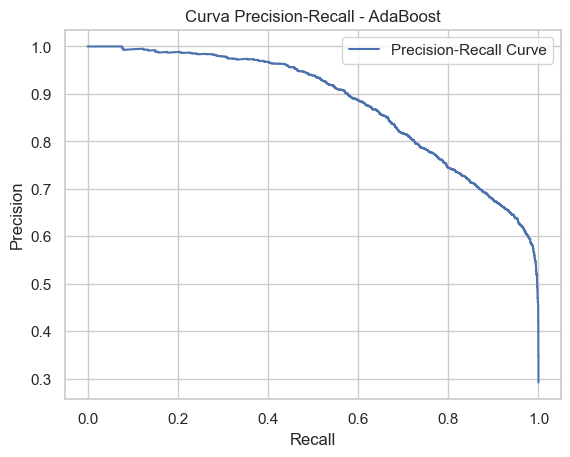

In [125]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import (
    accuracy_score, f1_score, recall_score, roc_auc_score, 
    confusion_matrix, roc_curve, precision_recall_curve
)
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from itertools import product

# Definir hiperparámetros a iterar
param_grid = {
    'n_estimators': [500],
    'learning_rate': [0.67, 0.68, 0.69],
    'estimator': [DecisionTreeClassifier(max_depth=7)]
}

# Almacenar resultados
results = []

# Iterar sobre todas las combinaciones de hiperparámetros
for params in product(*param_grid.values()):
    (n_estimators, learning_rate, estimator) = params
    
    # Construir el modelo
    model = AdaBoostClassifier(
        n_estimators=n_estimators,
        learning_rate=learning_rate,
        estimator=estimator,  # <--- Cambio aquí
        random_state=38
    )
    
    # Entrenar el modelo
    model.fit(X_train, y_train)
    
    # Predecir
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    
    # Calcular métricas
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    roc_auc = roc_auc_score(y_test, y_pred_proba) if len(np.unique(y_test)) > 1 else None
    
    # Validación cruzada
    cv_scores = cross_val_score(model, X_train, y_train, cv=5)
    mean_cv_score = np.mean(cv_scores)
    
    # Train Score
    train_score = model.score(X_train, y_train)
    
    # Evaluar sobreajuste
    if train_score > 1.5 * mean_cv_score:
        overfitting_warning = "SEVERE OVERFITTING"
    elif train_score > 1.2 * mean_cv_score:
        overfitting_warning = "DANGER"
    elif train_score > 1.1 * mean_cv_score:
        overfitting_warning = "MILD OVERFITTING"
    else:
        overfitting_warning = "OK"
    
    # Guardar resultados
    results.append({
        'n_estimators': n_estimators,
        'learning_rate': learning_rate,
        'estimator_depth': estimator.max_depth,
        'accuracy': accuracy,
        'f1_score': f1,
        'recall': recall,
        'roc_auc': roc_auc,
        'cv_score': mean_cv_score,
        'train_score': train_score,
        'overfitting': overfitting_warning
    })

# Convertir resultados a DataFrame y seleccionar los mejores modelos
results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by=['f1_score', 'accuracy'], ascending=False)

# Seleccionar los mejores modelos sin sobreajuste
best_models = results_df[results_df['overfitting'] == 'OK'].head(3)

display(best_models)

# Entrenar el mejor modelo y visualizar métricas
best_model_params = best_models.iloc[0].to_dict()
best_model = AdaBoostClassifier(
    n_estimators=best_model_params['n_estimators'],
    learning_rate=best_model_params['learning_rate'],
    estimator=DecisionTreeClassifier(max_depth=best_model_params['estimator_depth']),  # <--- Cambio aquí
    random_state=42
)
best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)
y_pred_proba = best_model.predict_proba(X_test)[:, 1]

# Matriz de Confusión
plt.figure()
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title(f'Matriz de Confusión - AdaBoost')
plt.show()

# Curva ROC
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.figure()
plt.plot(fpr, tpr, label=f"ROC Curve (AUC={roc_auc:.2f})")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC - AdaBoost')
plt.legend()
plt.show()

# Curva Precision-Recall
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
plt.figure()
plt.plot(recall, precision, label='Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Curva Precision-Recall - AdaBoost')
plt.legend()
plt.show()

## Gradient Boost

,criterion,max_depth,min_samples_split,min_samples_leaf,n_estimators,accuracy,f1_score,recall,roc_auc,cv_score,train_score,overfitting
0,friedman_mse,3,8,10,500,0.869423,0.867447,0.869423,0.94207,0.862249,0.874804,OK
1,friedman_mse,3,10,10,500,0.869423,0.867447,0.869423,0.94207,0.862249,0.874804,OK
2,friedman_mse,3,15,10,500,0.869423,0.867447,0.869423,0.94207,0.862249,0.874804,OK


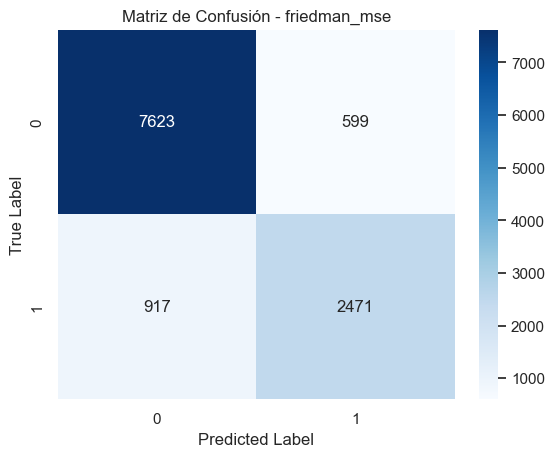

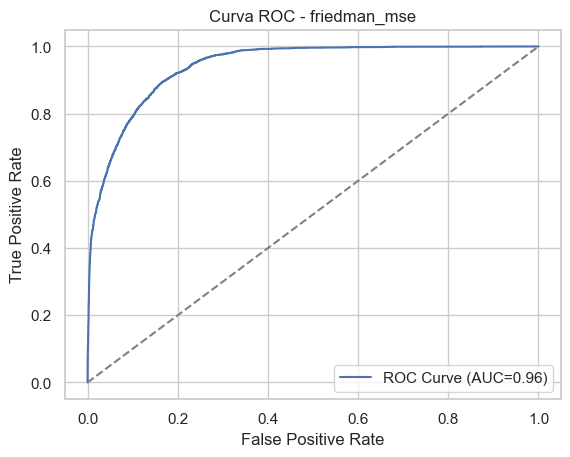

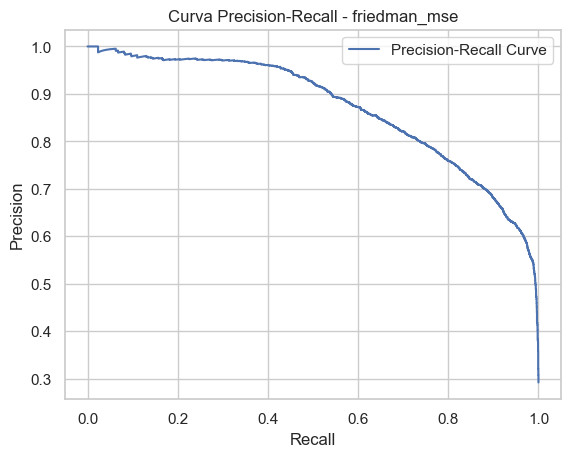

In [111]:
# Importar librerías necesarias
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from itertools import product
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import (
    accuracy_score, f1_score, recall_score, confusion_matrix, classification_report,
    roc_auc_score, roc_curve, precision_recall_curve
)

# Ignorar advertencias innecesarias
import warnings
warnings.filterwarnings("ignore")

# Definir variables
TARGET = "Mas_1_coche"  # Nombre de la variable objetivo
FEATURES = [col for col in df.columns if col != TARGET and col != "CODE" and col != "Tiempo"]

X = df[FEATURES]
y = df[TARGET]

# Dividir en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

param_grid = {
    'n_estimators': [500],  # Reducir el número de árboles
    'max_depth': [3, 10],  # Limitar la profundidad máxima
    'min_samples_split': [8, 10, 15],  # Reducir el número de combinaciones
    'min_samples_leaf': [10],  # Limitar las combinaciones de hojas
    'subsample': [1.0],  # Usar solo el 70% del conjunto de datos
    'criterion': ['friedman_mse'],  # Un solo criterio
}


# Almacenar resultados
results = []

# Iterar sobre todas las combinaciones de hiperparámetros
for params in product(*param_grid.values()):
    (
        n_estimators, max_depth, min_samples_split, min_samples_leaf,
        subsample, criterion
    ) = params

    # Construir el modelo con los hiperparámetros actuales
    model = GradientBoostingClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        subsample=subsample,
        criterion=criterion,
        random_state=38
    )
    
    # Entrenar el modelo
    model.fit(X_train, y_train)
    
    # Predecir en el conjunto de prueba
    y_pred = model.predict(X_test)
    
    # Calcular métricas
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    
    # Calcular ROC-AUC si hay más de una clase
    if len(np.unique(y_test)) > 1:
        y_pred_proba = model.predict_proba(X_test)[:, 1]
        roc_auc = roc_auc_score(y_test, y_pred_proba)
    else:
        roc_auc = None
    
    # Validación cruzada
    cv_scores = cross_val_score(model, X_train, y_train, cv=3)
    mean_cv_score = np.mean(cv_scores)
    
    # Calcular Train Score
    train_score = model.score(X_train, y_train)
    
    # Determinar si hay sobreajuste
    if train_score > 1.5 * mean_cv_score:
        overfitting_warning = "SEVERE OVERFITTING"
    elif train_score > 1.2 * mean_cv_score:
        overfitting_warning = "DANGER"
    elif train_score > 1.1 * mean_cv_score:
        overfitting_warning = "MILD OVERFITTING"
    else:
        overfitting_warning = "OK"

    # Guardar los resultados
    results.append({
        'criterion': criterion,
        'max_depth': max_depth,
        'min_samples_split': min_samples_split,
        'min_samples_leaf': min_samples_leaf,
        'n_estimators': n_estimators,
        'accuracy': accuracy,
        'f1_score': f1,
        'recall': recall,
        'roc_auc': roc_auc,
        'cv_score': mean_cv_score,
        'train_score': train_score,
        'overfitting': overfitting_warning
    })

# Convertir resultados a DataFrame y seleccionar los 3 mejores modelos
results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by=['f1_score', 'accuracy'], ascending=False)

# Seleccionar el mejor modelo sin sobreajuste y optimizando F1 Score
best_models = results_df[results_df['overfitting'] == 'OK'].head(3)

# Visualizar los mejores modelos
from IPython.display import display
display(best_models)

# Matriz de confusión y Curvas ROC/Precision-Recall del mejor modelo
best_model_params = best_models.iloc[0].to_dict()
best_model = GradientBoostingClassifier(
    n_estimators=best_model_params["n_estimators"],
    max_depth=best_model_params["max_depth"],
    min_samples_split=best_model_params["min_samples_split"],
    min_samples_leaf=best_model_params["min_samples_leaf"],
    criterion=best_model_params["criterion"],
    random_state=42
)
best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)
y_pred_proba = best_model.predict_proba(X_test)[:, 1]

# Matriz de Confusión
plt.figure()
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title(f'Matriz de Confusión - {best_model_params["criterion"]}')
plt.show()

# Curva ROC
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.figure()
plt.plot(fpr, tpr, label=f"ROC Curve (AUC={roc_auc:.2f})")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'Curva ROC - {best_model_params["criterion"]}')
plt.legend()
plt.show()

# Curva Precision-Recall
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
plt.figure()
plt.plot(recall, precision, label='Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title(f'Curva Precision-Recall - {best_model_params["criterion"]}')
plt.legend()
plt.show()

## Predict para el mejor modelo

In [132]:
import joblib

# Guardar el modelo entrenado en un archivo
joblib.dump(best_model, "data/stg/xgboost_model.pkl")


['data/stg/xgboost_model.pkl']

In [133]:
# Cargar el modelo entrenado
loaded_model = joblib.load("data/stg/xgboost_model.pkl")

In [130]:
if hasattr(loaded_model, "get_booster"):
    print("El modelo está correctamente cargado y entrenado.")
else:
    print("El modelo no está entrenado. Asegúrate de haberlo guardado después de `fit()`.")


El modelo está correctamente cargado y entrenado.


In [134]:
# Predecir con el modelo cargado
y_pred = loaded_model.predict(X_test)
y_pred_proba = loaded_model.predict_proba(X_test)[:, 1]

# Calcular métricas
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
roc_auc = roc_auc_score(y_test, y_pred_proba)

# Mostrar métricas
print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Recall: {recall:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")


NotFittedError: need to call fit or load_model beforehand